<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/interferometro_michelson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importazione dei dati
importo il dataset dell'esperimento

In [0]:
import pandas as pd
import numpy as np
import scipy.constants as cost

# !pip install uncertainties
from uncertainties import unumpy

import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [0]:
path = "https://www.dropbox.com/s/hcbw9p2c8utgwdq/Dati_Michelson-v4.xlsx?dl=1"
# inserisco i dati in un dataset pandas.
data = pd.read_excel(path, names=[
    "dl", "vmax", "svmax", "vmin", "svmin"
  ]
)
data['sdl'] = 0.1 # 1mm uncertainty on lengths
data['tau'] = data['dl']*2/29.98 # [ns]
data['stau'] = data['sdl']*2/29.98 # [ns]
vmax = unumpy.uarray(data.vmax, data.svmax)
vmin = unumpy.uarray(data.vmin, data.svmin)
tau = unumpy.uarray(data.tau, data.stau)

vis = (vmax - vmin) / (vmax + vmin) # automatically evaluates uncertainties
data['vis'] = unumpy.nominal_values(vis)
data['svis'] = unumpy.std_devs(vis)

Per calcolare la visibilità avrò bisogno di mettere a confronto il minimo ed il massimo dell'intensità, creo quindi una funzione per farlo.

In [0]:
import scipy.odr as odr
from scipy.stats import kstest

''' Performs the fit
Needed Parameters (key-word):
  function: function with 2 arguments:
    array-like object for parameters (float-like)
    array-like object for variables (float-like)
  par0: array-like object for parameters prior (float-like)
  par_names: array-like object for parameters prior (string)
  file_name: csv with data
Returns:
  tuple with array of parameters and pvalue
'''
def fit(function=None, par0=None, par_names=None,
        x=None, y=None, sx=None, sy=None,
        xlabel="", ylabel="", title="", xres = 100):

  fit_data = odr.RealData(x, y=y, sx=sx, sy=sy)
  model = odr.Model(function)
  fit = odr.ODR(fit_data, 
                model, 
                beta0=par0)
  out = fit.run()

  par = out.beta
  par_s = out.sd_beta
  for i in range(len(par_names)):
    print(f'{par_names[i]} : {par[i]:.3f} +- {par_s[i]:.3f}')

  plt.errorbar(x, y, xerr=sx, yerr=sy,
    ecolor='black', fmt='o', color='black', markersize=2
  )
  d_x = max(x)-min(x)
  x = np.linspace(min(x)-d_x/10, max(x)+d_x/10, xres)
  d_y = max(y)-min(y)
  plt.ylim(min(y)-d_y/10, max(y)+d_y/10)
  plt.plot(x, function(par, x), color='blue')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()
  '''
  kolmogorov-smirnov test on normalized residuals is performed
  it tests the similarity between normalized residuals and a normalized gaussian
  this similarity implies a reasonable belief in goodnes of fit and
  correct estimation of uncertainties
  if pvalue is > 0.05 the fit is accepted
  '''
  y_res_norm = out.eps/sy
  plt.hist(y_res_norm)
  plt.title("Residuals histogram")
  plt.show()
  pvalue = kstest(y_res_norm, 'norm').pvalue
  print(f"p_value: {pvalue:.3f}")

  return out

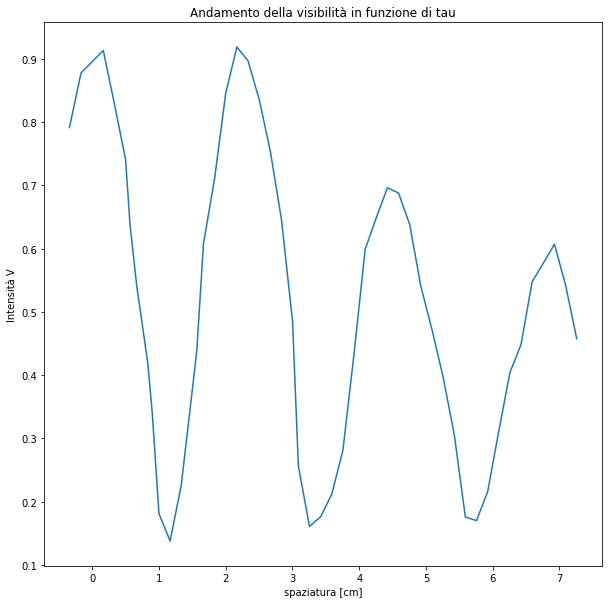

In [0]:
plot(data['Visibilità'], data['tempo [ns]'], title='Andamento della visibilità in funzione di tau',
     ylabel = 'Intensità V', xlabel = 'spaziatura [cm]')

sigma : 0.148 +- 0.010
N : 2.000 +- 0.001
Domega : 2.747 +- 0.011


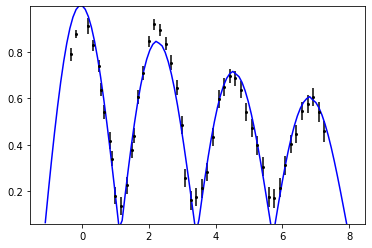

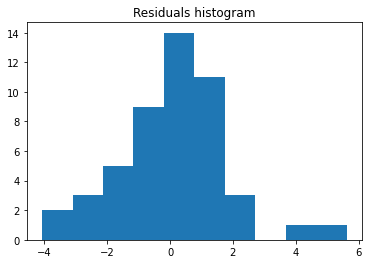

p_value: 0.184


In [0]:
def rs(par, t):
    sigma = par[0]
    N = par[1]
    Domega = par[2]
    y = np.exp(-sigma*t/2)/N*np.abs(np.sin(N*Domega*t/2)/np.sin(Domega*t/2))
    return y
fitted = fit(rs, x = data['tempo [ns]'], y = data['Visibilità'], sy = data['sigma[V]'], sx = data['sigma[t] [ns]'],
    par0 = [0.16, 2, 2.7], par_names=['sigma', 'N', 'Domega'], xres=100)

In [0]:
  par = fitted.beta
  par_s = fitted.sd_beta
  tau = 2/par[0]
  stau = par_s[0]/(par[0]*par[0])
  print(f'tau value: ({tau : .1f} +- {stau: .1f})ns')

tau value: ( 13.5 +-  0.5)ns


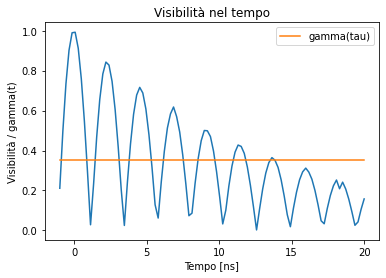

In [0]:
x = np.linspace(-1, 20, 100)
plt.plot(x, rs(par, x))
plt.plot(x, [rs(par, tau)]*len(x), label = 'gamma(tau)')
plt.title('Visibilità nel tempo')
plt.xlabel('Tempo [ns]')
plt.ylabel('Visibilità / gamma(t)')
plt.legend()

In [0]:
# lunghezza della cavità
L = cost.pi*cost.c/(par[2]*1e9)
sL = cost.pi*cost.c*par_s[2]*1e9/(par[2]*1e9)**2
print(f'Lunghezza della cavità del laser: ({L:.3f} +- {sL:.3f})m')

Lunghezza della cavità del laser: (0.343 +- 0.001)m


sigma : 0.017 +- 0.006
N : 2.999 +- 0.004
Domega : 2.741 +- 0.018


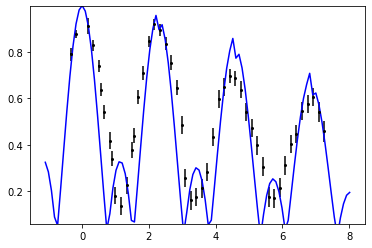

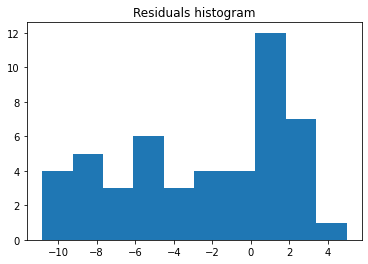

p_value: 0.000


In [0]:
#verifica dell'ipotesi dei 3 modi
def rs(par, t):
    sigma = par[0]
    N = par[1]
    Domega = par[2]
    y = np.exp(-sigma*t**2/2)/N*np.abs(np.sin(N*Domega*t/2)/np.sin(Domega*t/2))
    return y
fit(rs, x = data['tempo [ns]'], y = data['Visibilità'], sy = data['sigma[V]'], sx = data['sigma[t] [ns]'],
    par0 = [0.16, 3, 2.76], par_names=['sigma', 'N', 'Domega'])